### Кластеризация клеток периферической крови от здорового донора после single-cell RNA sequencing

In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import scanpy.external as sce
from sklearn.cluster import KMeans

In [ ]:
warnings.filterwarnings("ignore") # Отключаем warning'и, которые могут мешать по ходу работы
sc.settings.verbosity = 3 # Делаем так, чтобы scanpy выводил максимально подробные логи

# Настраиваем общую эстетику картинок
sc.settings.set_figure_params(dpi=100) # Качество картинок
sns.set(font_scale=1) # Размер шрифта
sns.set_style("ticks") # Стиль картинок

In [ ]:
adata_unfiltered = sc.read_10x_h5("outs/raw_feature_bc_matrix.h5") # Загружаем нефильтрованный датасет
print(adata_unfiltered)

reading outs/raw_feature_bc_matrix.h5
 (0:00:21)
AnnData object with n_obs × n_vars = 3069478 × 36601
    var: 'gene_ids', 'feature_types', 'genome'


In [ ]:
adata_unfiltered.obs.head() # Шапка датафрейма с аннотацией клеток, кроме баркодов пока ничего нет, но возможно добавление столбцов с указанием тканей или органов

""
AAACCCAAGAAACACT-1
AAACCCAAGAAACCAT-1
AAACCCAAGAAACCCA-1
AAACCCAAGAAACCTG-1
AAACCCAAGAAACTAC-1


In [ ]:
adata_unfiltered.var.head() # Шапка датафрейма с аннотацией генов

,gene_ids,feature_types,genome
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38
FAM138A,ENSG00000237613,Gene Expression,GRCh38
OR4F5,ENSG00000186092,Gene Expression,GRCh38
AL627309.1,ENSG00000238009,Gene Expression,GRCh38
AL627309.3,ENSG00000239945,Gene Expression,GRCh38


Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

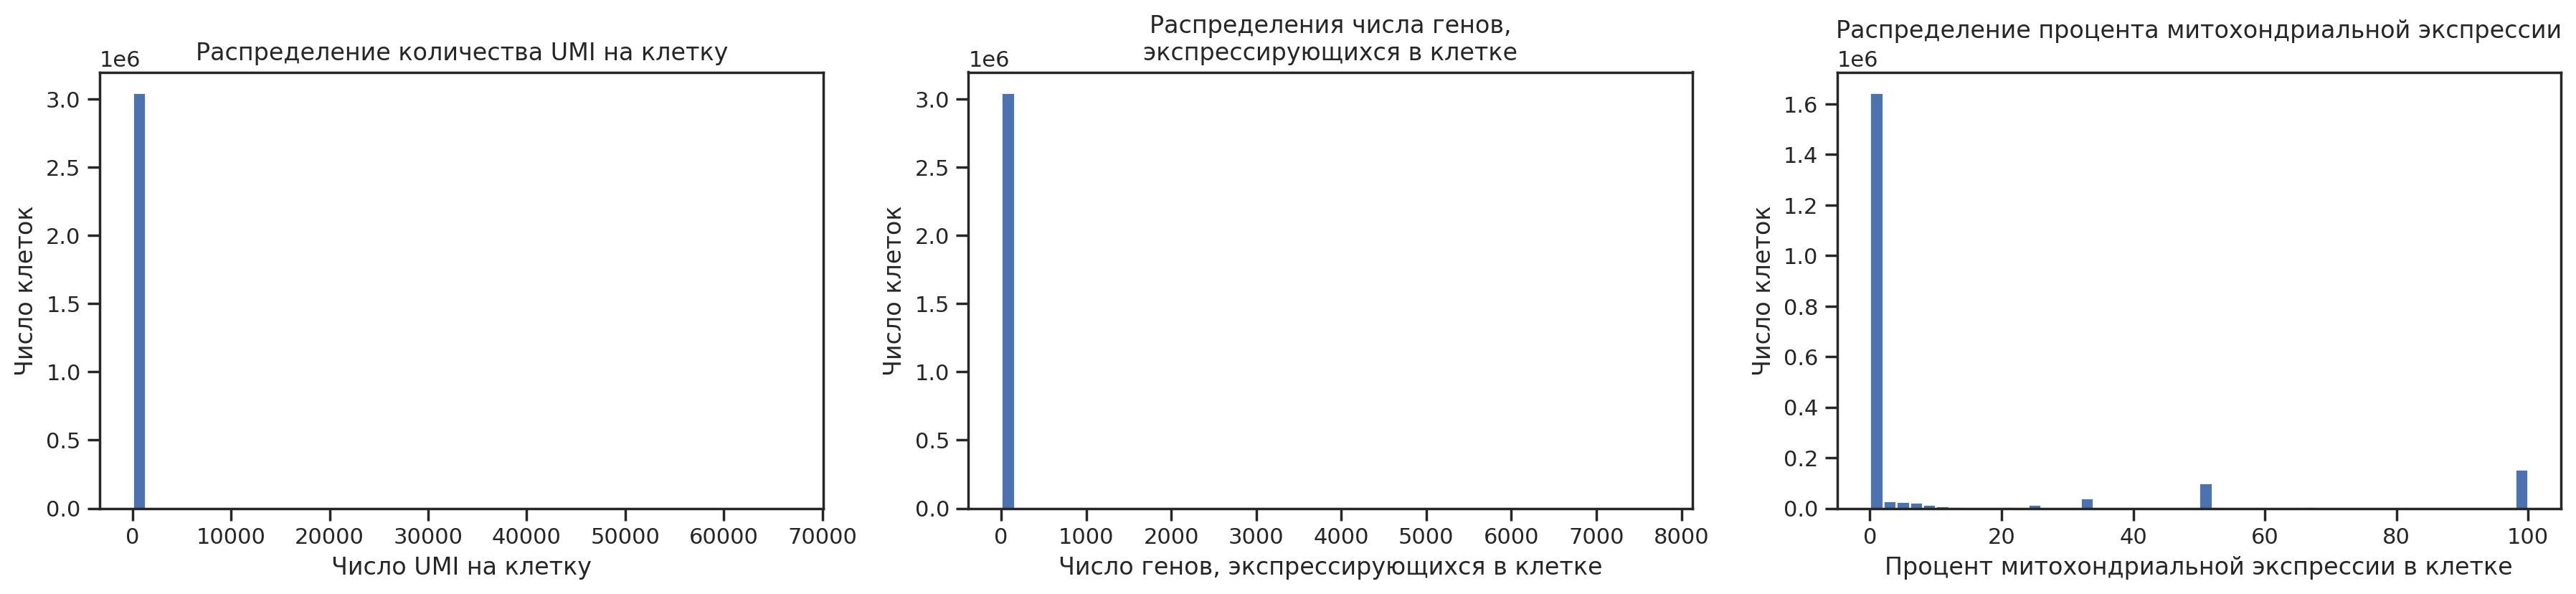

In [ ]:
adata_unfiltered.var["mt"] = adata_unfiltered.var_names.str.startswith("MT-") # В датафрейме с описанием генов делаем отдельный столбик, в котором будет храниться True, если ген митохондриальный
sc.pp.calculate_qc_metrics(adata_unfiltered, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True) # Подсчитываем QC

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4)) # Создаём сетку, чтобы отрисовать три графика

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов,\nэкспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

Подавляющее большинство «клеток» имеют околонулевую экспрессию. фильтруем клетки, оставляем только те, что экспрессируют ≥ 100 UMI на клетку

Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

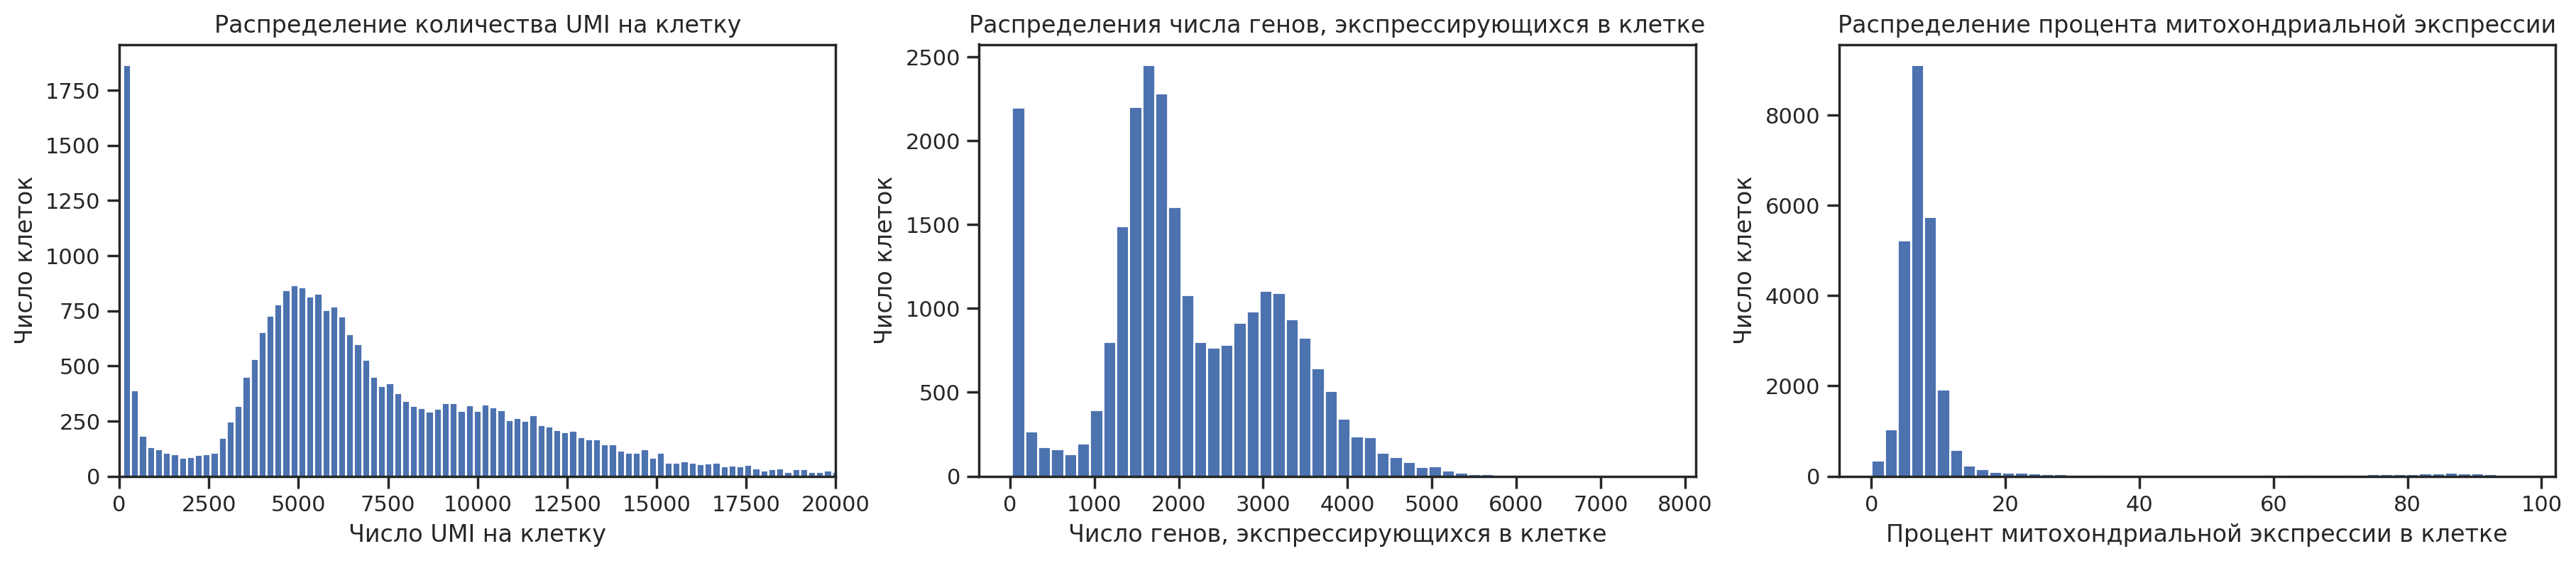

In [ ]:
adata_unfiltered = adata_unfiltered[adata_unfiltered.obs.total_counts >= 100] # Оставляем только те клетки, у которых суммарно ≥ 100 UMI

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4))

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1}, bins=300)
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")
axs[0].set_xlim(0, 20000)

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов, экспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

Картина сильно улучшилась. Однако мы до сих пор видим сильный пик в начале. Для того, чтобы от него избавиться, можно просто в ручную посмотреть минимум между двумя пиками (например, по числу генов) — здесь он находится где-то на 500 генах. Также можно избавиться от клеток, у которых больше 25% экспрессии приходится на гены, закодированные в митохондриальной ДНК.

Text(0.5, 1.0, 'Распределение процента митохондриальной экспрессии')

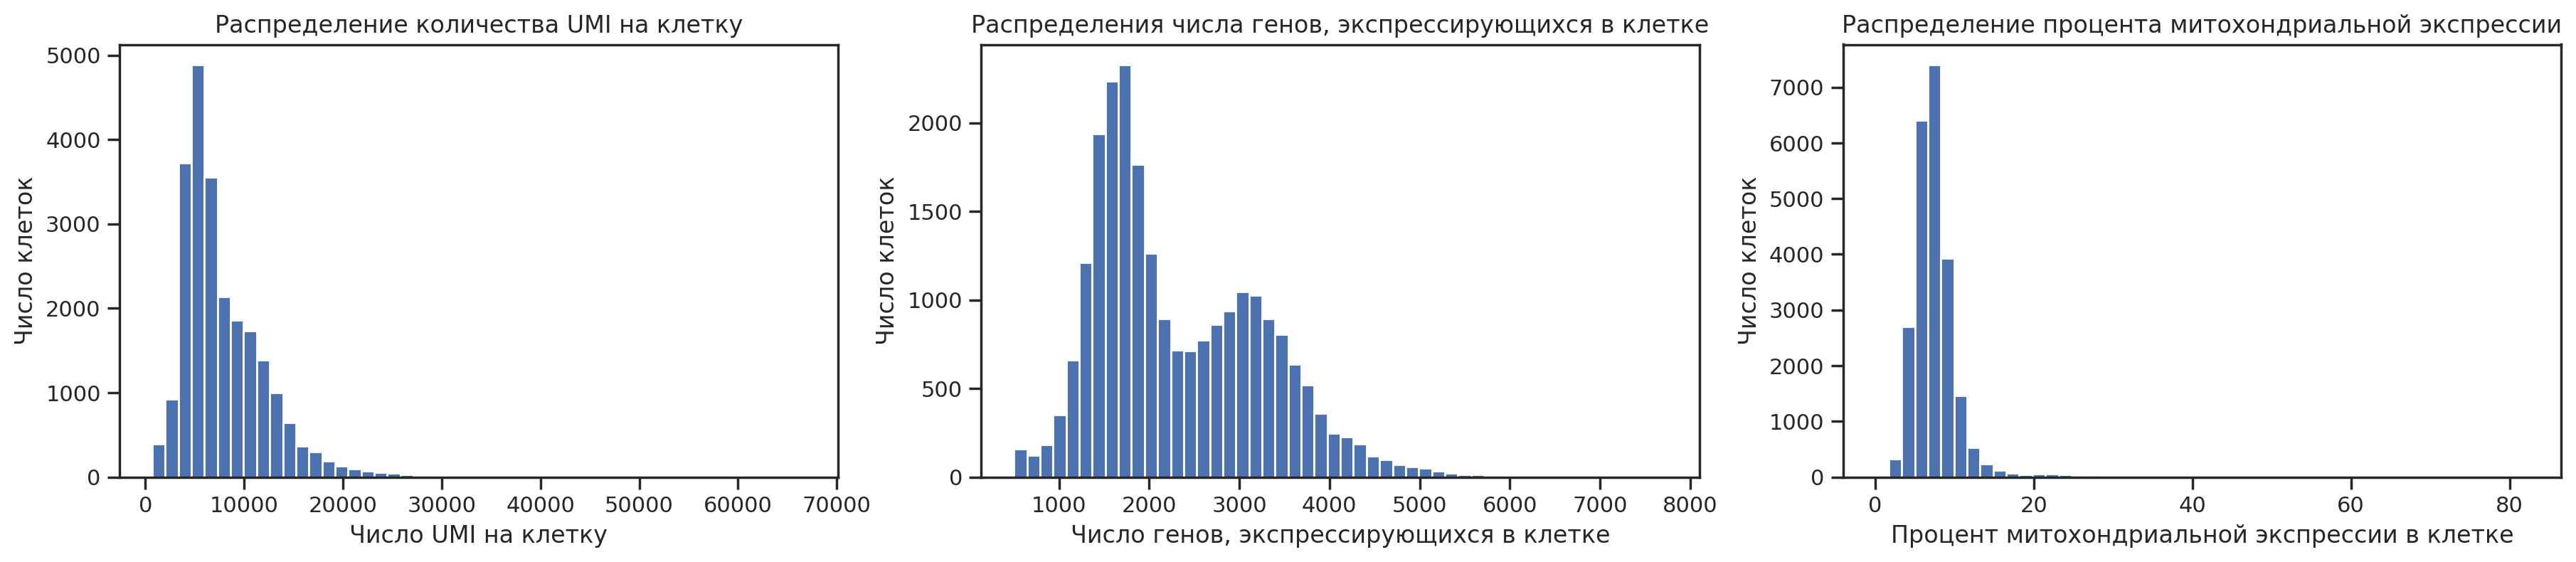

In [ ]:
adata_unfiltered = adata_unfiltered[adata_unfiltered.obs.n_genes_by_counts >= 500] # Оставляем только те клетки, у которых суммарно ≥ 500 генов
adata = adata_unfiltered[adata_unfiltered.obs.pct_counts_mt <= 20] # Оставляем только те клетки, у которых меньше 20% митохондриальной экспрессии

# Строим графики
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(22, 4)) 

# Отрисовываем распределение общего числа UMI
sns.distplot(adata_unfiltered.obs["total_counts"], kde=False, ax=axs[0], hist_kws={"alpha":1})
axs[0].set_xlabel("Число UMI на клетку")
axs[0].set_ylabel("Число клеток")
axs[0].set_title("Распределение количества UMI на клетку")

# Отрисовываем распределение числа генов по клеткам
sns.distplot(adata_unfiltered.obs["n_genes_by_counts"], kde=False, ax=axs[1], hist_kws={"alpha":1})
axs[1].set_xlabel("Число генов, экспрессирующихся в клетке")
axs[1].set_ylabel("Число клеток")
axs[1].set_title("Распределения числа генов, экспрессирующихся в клетке")

# Отрисовываем распределение митохондриальной экспрессии
sns.distplot(adata_unfiltered.obs["pct_counts_mt"], kde=False, ax=axs[2], hist_kws={"alpha":1})
axs[2].set_xlabel("Процент митохондриальной экспрессии в клетке")
axs[2].set_ylabel("Число клеток")
axs[2].set_title("Распределение процента митохондриальной экспрессии")

In [ ]:
adata.write_h5ad("10x.h5ad") #записываем в формат AnnData наши данные, чтобы была возможность их в любой момент прочитать

In [ ]:
adata = sc.read_h5ad("10x.h5ad")

Выявление и устранение дублетов

In [ ]:
sce.pp.scrublet(adata)

Running Scrublet
filtered out 12617 genes that are detected in less than 3 cells
normalizing counts per cell
    finished (0:00:00)
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
Embedding transcriptomes using PCA...
Automatically set threshold at doublet score = 0.19
Detected doublet rate = 5.2%
Estimated detectable doublet fraction = 61.2%
Overall doublet rate:
	Expected   = 5.0%
	Estimated  = 8.5%
    Scrublet finished (0:01:01)


In [ ]:
adata.obs.to_csv("adata_obs.tsv", sep="\t")

In [ ]:
obs = pd.read_csv("adata_obs.tsv", sep="\t", index_col=0)
adata.obs = obs

Теперь в adata.obs у нас появилась дополнительная колонка: predicted_doublets

In [ ]:
adata.obs.predicted_doublet

AAACCCAAGAGCAGCT-1    False
AAACCCACAATACCTG-1    False
AAACCCACACAACCGC-1    False
AAACCCACACACAGAG-1     True
AAACCCACAGATCATC-1    False
                      ...  
TTTGTTGGTTCAAGGG-1    False
TTTGTTGTCACCTGGG-1    False
TTTGTTGTCATTGAGC-1    False
TTTGTTGTCCGATGTA-1    False
TTTGTTGTCGTGGCTG-1    False
Name: predicted_doublet, Length: 23232, dtype: bool

Удаляем дублеты

In [ ]:
print(f"Обнаруженное число дублетов: {sum(adata.obs.predicted_doublet)} (из {len(adata)} клеток всего)")
adata = adata[~adata.obs.predicted_doublet]
print(adata)

Обнаруженное число дублетов: 1213 (из 23232 клеток всего)
View of AnnData object with n_obs × n_vars = 22019 × 36601
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'scrublet'


In [ ]:
print("Суммы UMI на клетку до нормировки:", adata.X.sum(axis=1).T)

sc.pp.normalize_total(adata) # Нормировка
print("Суммы UMI на клетку после нормировки:", adata.X.sum(axis=1).T)

Суммы UMI на клетку до нормировки: [[ 9203.  5705.  8877. ...  6433. 12527.  4419.]]
normalizing counts per cell
    finished (0:00:00)
Суммы UMI на клетку после нормировки: [[6415.     6414.9995 6415.     ... 6414.999  6415.0005 6414.999 ]]


In [ ]:
sc.pp.log1p(adata) # логарифмирование данных

Подготовка к кластеризации и снижению размерности

Выделяем самые высоко вариабельные гены. Это необходимо, чтобы амплифицировать сигнал, которая у нас есть в нашем датасете.

In [ ]:
sc.pp.highly_variable_genes(adata, n_top_genes=3000)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:02)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


Теперь в описании adata.var есть отдельное поле, которое сообщает нам, является ли ген высоко вариабельным.

In [ ]:
adata.var.head() # Выводим верхушку adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
MIR1302-2HG,ENSG00000243485,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
FAM138A,ENSG00000237613,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
OR4F5,ENSG00000186092,Gene Expression,GRCh38,False,0,0.000000,100.000000,0.0,False,1.000000e-12,NaN,NaN
AL627309.1,ENSG00000238009,Gene Expression,GRCh38,False,79,0.000026,99.997426,79.0,False,2.445431e-03,0.211114,0.234543
AL627309.3,ENSG00000239945,Gene Expression,GRCh38,False,12,0.000004,99.999609,12.0,False,4.602156e-04,0.231808,0.292726


In [ ]:
adata.raw = adata #Сохраняем исходные данные в отдельный объект

Дальше оставляем в нашем объекте только гены, которые мы отнесли к HVG

In [ ]:
adata = adata[:, adata.var.highly_variable] # Оставляем только подмножество генов, которые относятся к HVG
print(adata)

View of AnnData object with n_obs × n_vars = 22019 × 3000
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'scrublet', 'log1p', 'hvg'


Снижение размерности и кластеризация
Проводим анализ методом главных компонент. Это
позволит получить первичное представление о том, как данные распределены в пространстве,
потребуется дальше, потому что первые N компонент PCA сохраняют максимальную биологическую значимость и в это же время устраняют шумы.

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:06)


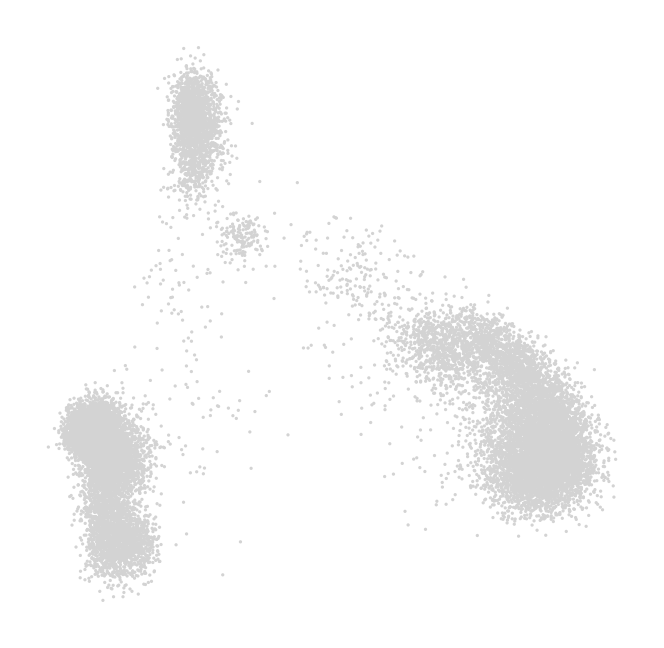

In [ ]:
sc.tl.pca(adata) # Вычисляем PCA
sc.pl.pca(adata, frameon=False) # Отрисовываем PCA

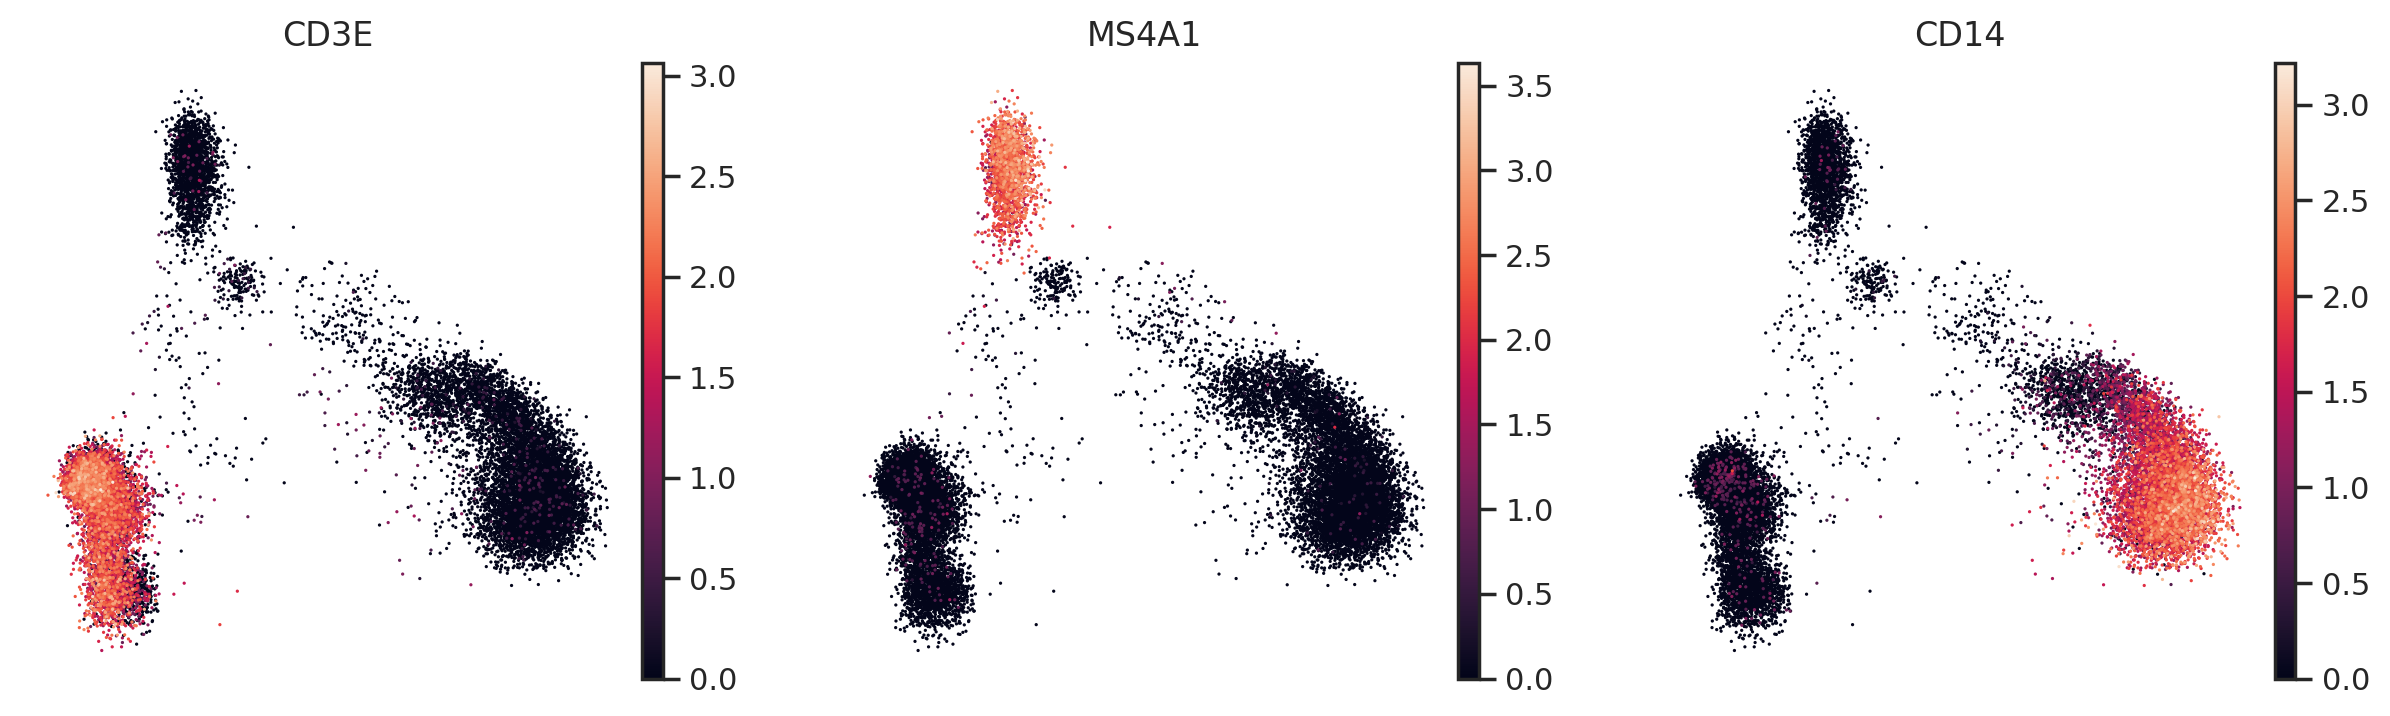

In [ ]:
sc.pl.pca(adata, color=["CD3E", "MS4A1", "CD14"], frameon=False) # Отрисовываем PCA по 3 типам клеток

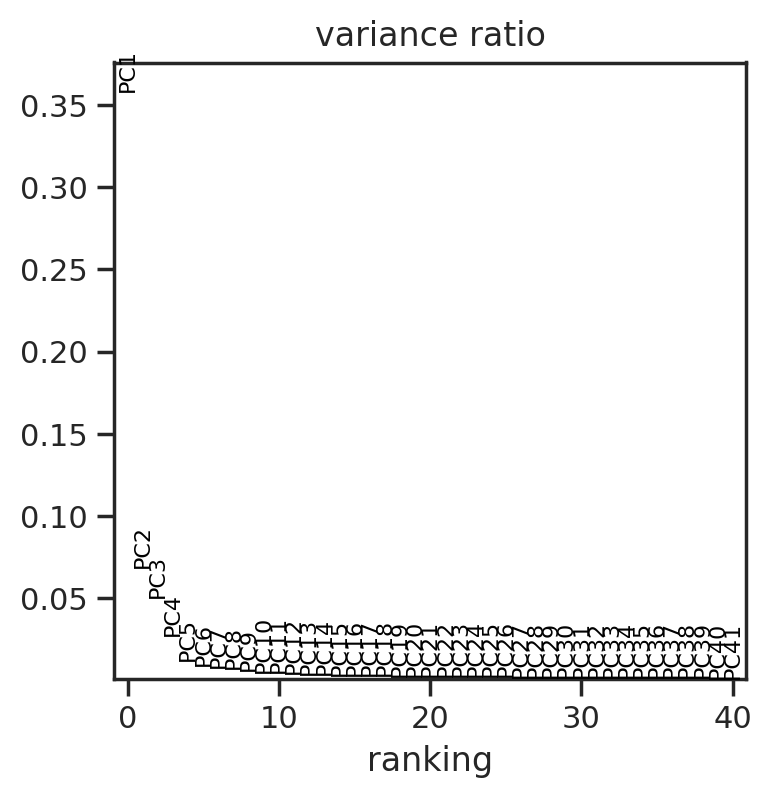

In [ ]:
sc.pl.pca_variance_ratio(adata, log=False, n_pcs=40)

Снижение размерности при помощи UMAP и t-SNE. 

In [ ]:
sc.pp.neighbors(adata, n_pcs=30) # Вычисление графа соседей - это необходимая стадия перед UMAP и t-SNE
sc.tl.umap(adata) # Рассчёт UMAP

In [ ]:
sc.pl.umap(adata, frameon=False, title="UMAP") # Отрисовываем UMAP

In [ ]:
sc.tl.tsne(adata)
sc.pl.tsne(adata, color=["CD3E", "MS4A1", "CD14"], frameon=False, title="TSNE")

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "CD3E", "CD8A", "NKG7", "GZMA", "IL7R",
        "FOXP3", "CD14", "FCGR3A", "CD19", "MS4A1",
        "CLEC9A", "CD1C", "TCF4",
      ],
    frameon=False
)

In [ ]:
sc.tl.leiden(adata) # Кластеризация алгоритмом Leiden

running Leiden clustering
    finished: found 17 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:05)


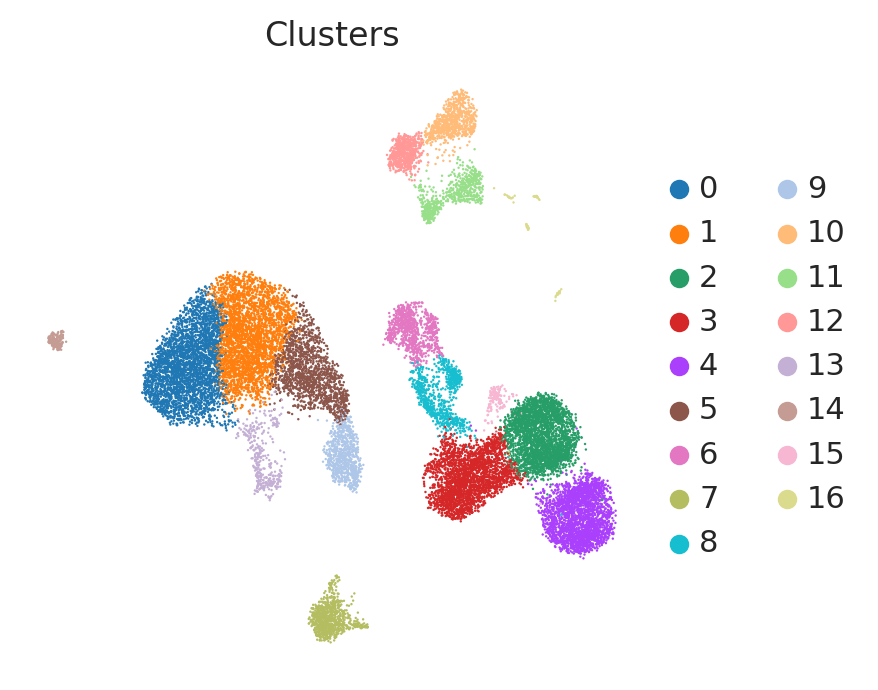

In [ ]:
sc.pl.umap(adata, color="leiden", frameon=False, title="Clusters", s=3) # Отрисовываем UMAP

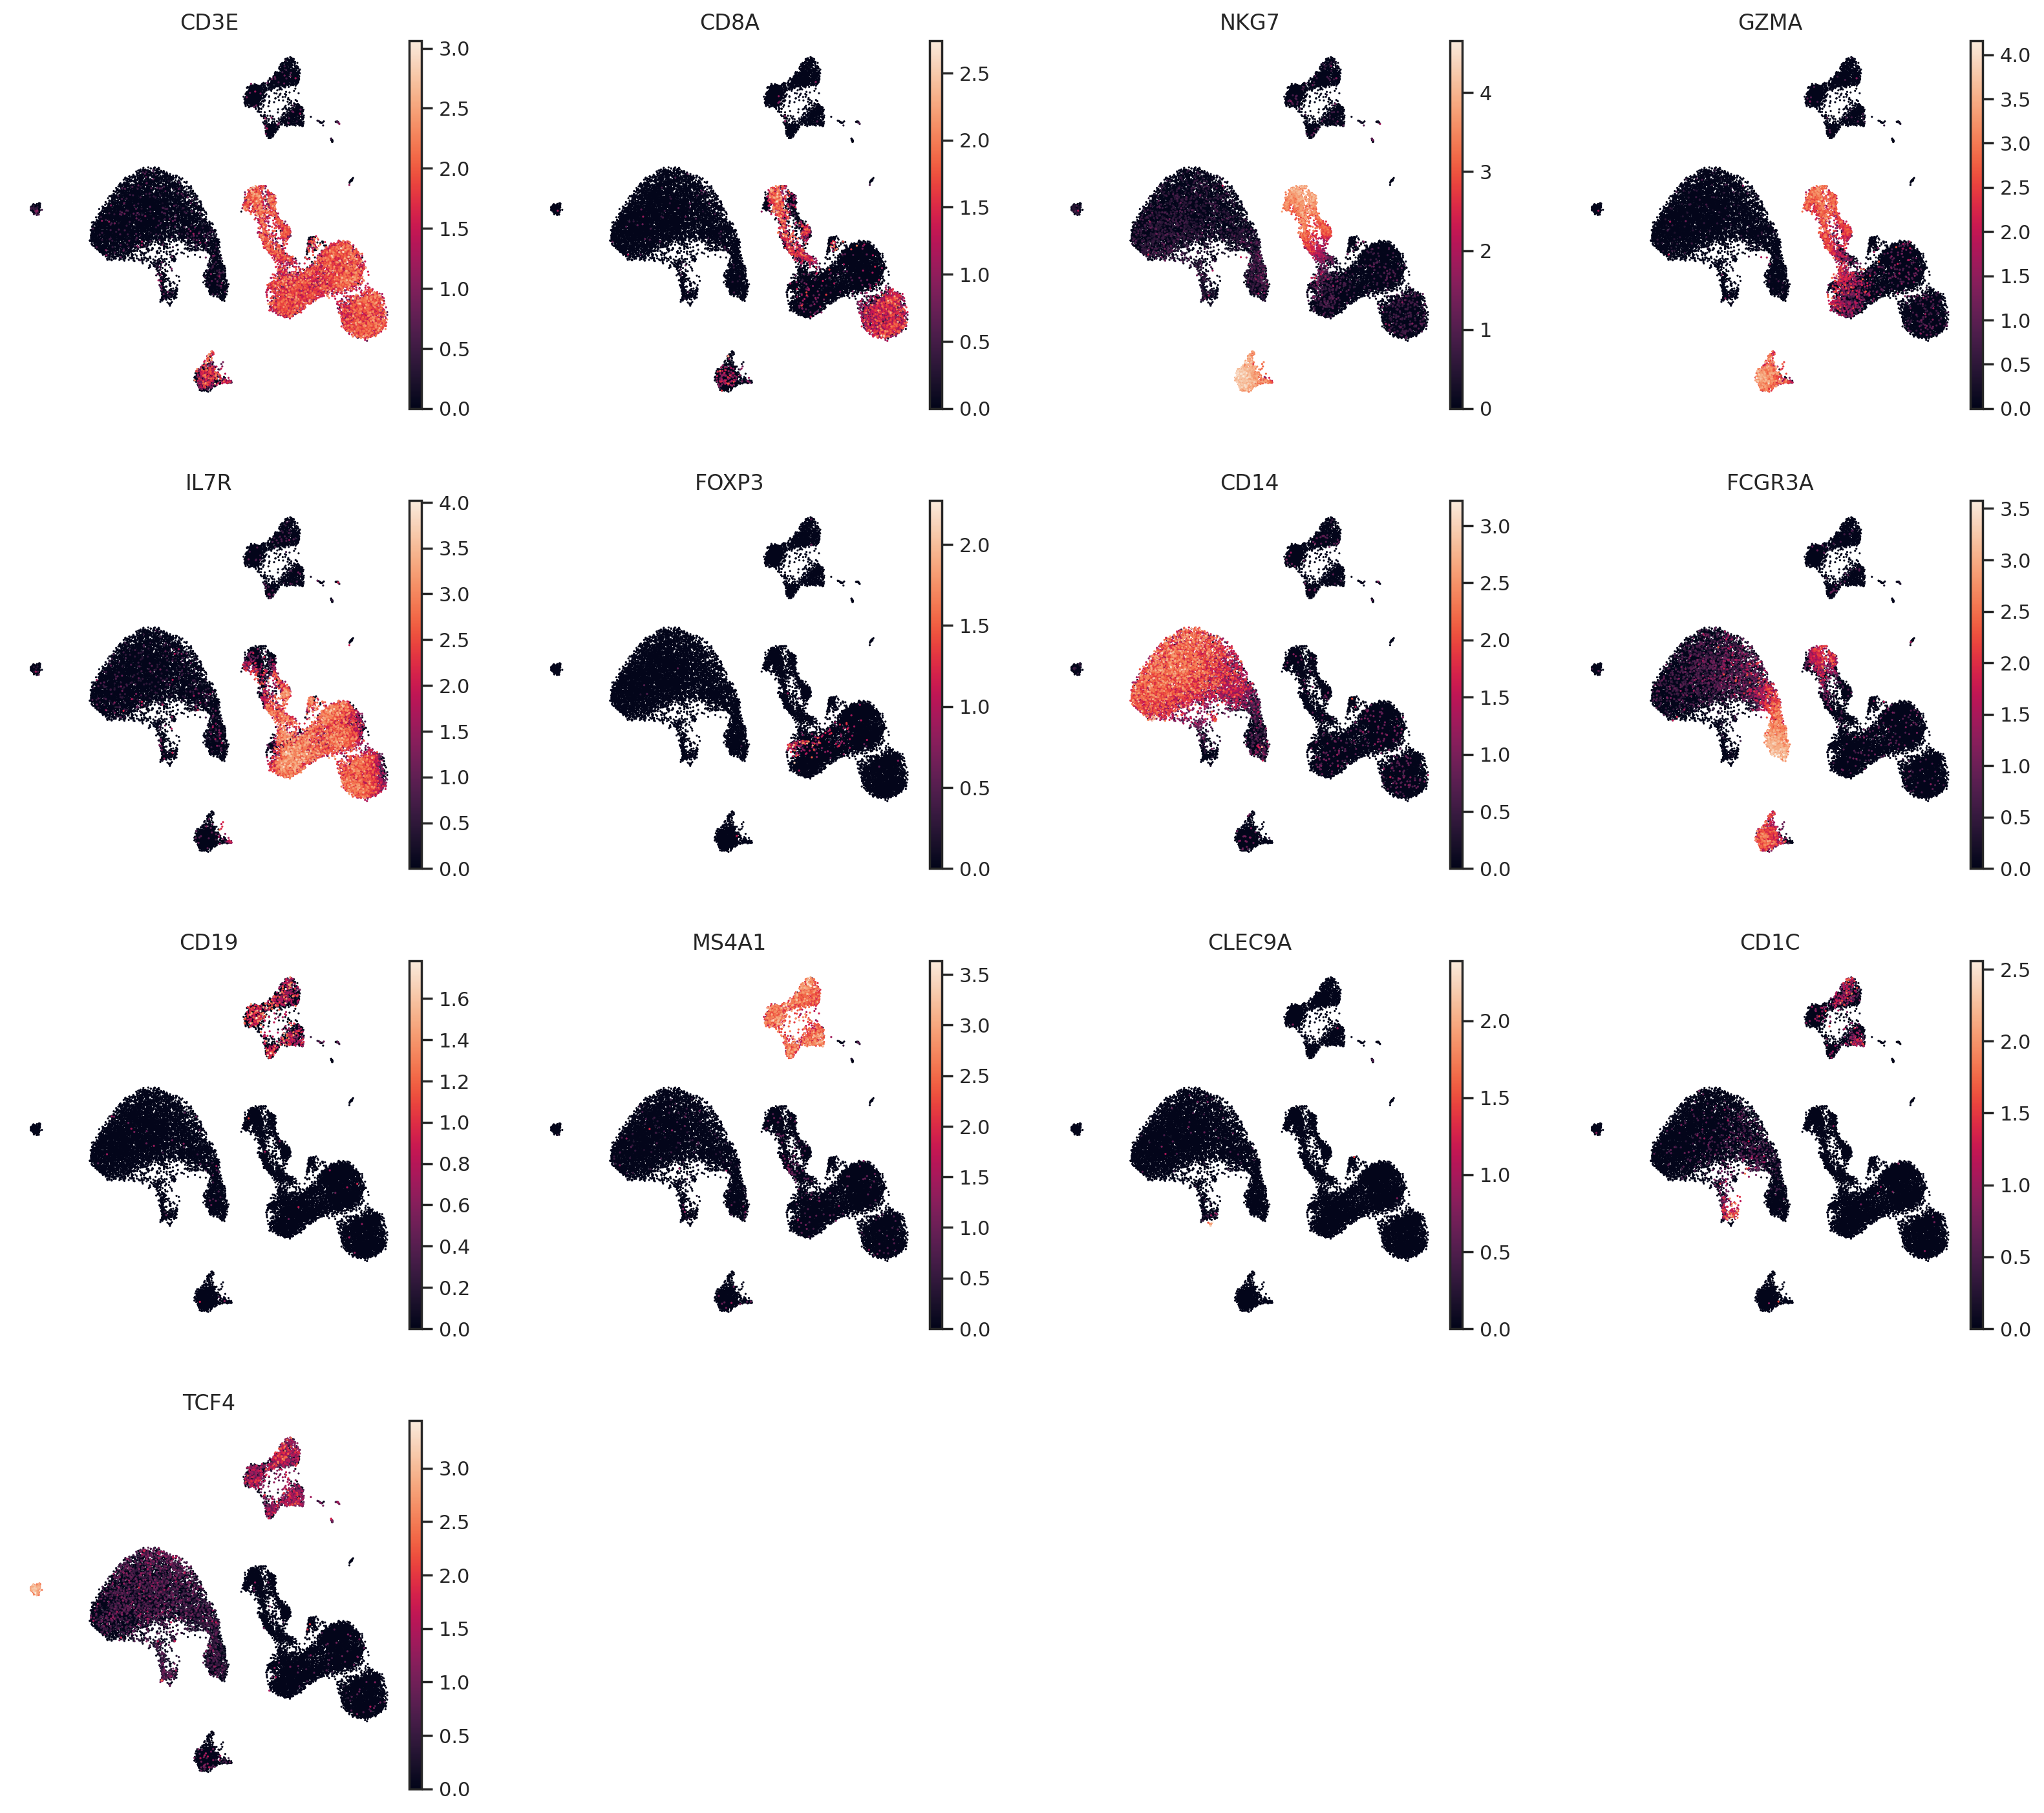

In [ ]:
sc.pl.umap(
    adata,
    color=[
        "CD3E", "CD8A", "NKG7", "IL7R",
        "FOXP3", "CD14", "FCGR3A", "CD19"
      ],
    frameon=False
)

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
running Leiden clustering
    finished: found 16 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


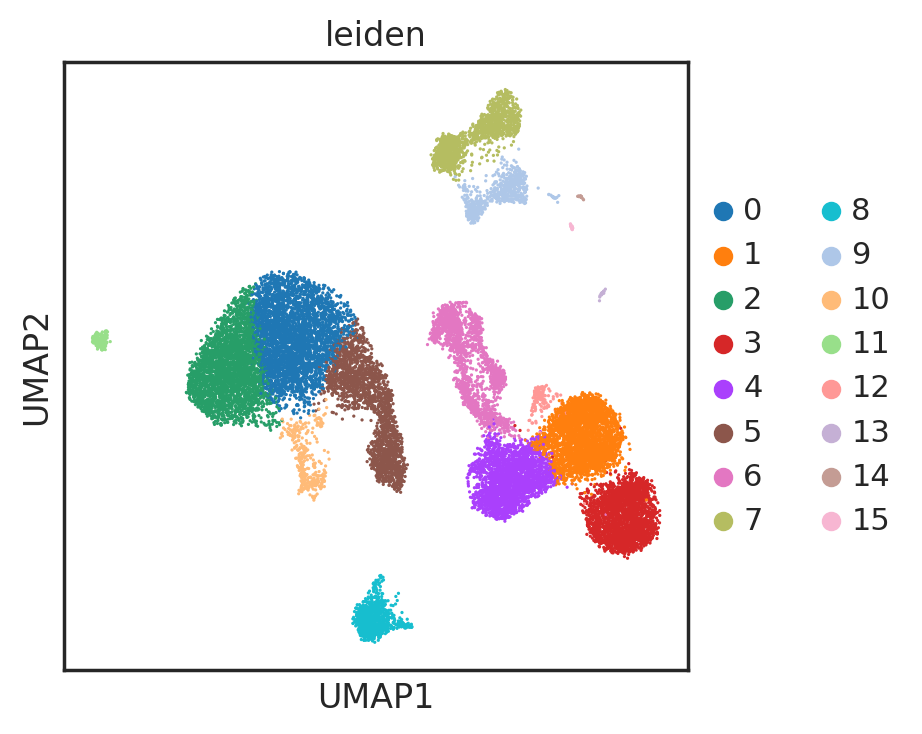

In [ ]:
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.5)
sc.pl.umap(adata, color="leiden")

In [ ]:
# Словарь с маркерными генами
marker_genes_dict = {
    "T-cells" : ["CD3E", "CD4", "CD8A"], 
    "Naive T-cells" : ["CCR7", "SELL", "COTL1"],
    "Memory CD4+ T-cells" : ["ITGB1", "LGALS1"],
    "Cytotoxic T-cells" : ["CCL5", "GZMA"],
    "MAIT T-cells" : ["KLRB1", "SLC4A10"],
    "NK cells" : ["GNLY", "GZMB", "NCAM1"],
    "Progenitor cells" : ["CD34"], 
    "Erythrocytes" : ["HBA1", "HBB"],
    "Monocytes": ["LYZ", "CD14", "FCGR3A"],
    "cDC1" : ["C1orf54", "CLEC9A"],
    "cDC2" : ["ENHO", "CD1C"],
    "pDC" : ["TCF4", "ITM2C", "IRF7"],
    "B-cells" : ["MS4A1"]
} 

In [ ]:
adata.var

,gene_ids,feature_types,genome,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
HES4,ENSG00000188290,Gene Expression,GRCh38,False,1892,1.340945e-03,99.938361,4116.0,True,0.086987,0.700527,1.610559
ISG15,ENSG00000187608,Gene Expression,GRCh38,False,16277,1.980728e-02,99.469714,60798.0,True,1.001048,1.677812,2.041196
TNFRSF18,ENSG00000186891,Gene Expression,GRCh38,False,950,4.512168e-04,99.969050,1385.0,True,0.060611,0.940349,2.284835
TNFRSF4,ENSG00000186827,Gene Expression,GRCh38,False,1067,5.339670e-04,99.965238,1639.0,True,0.062909,0.903629,2.181596
AL391244.2,ENSG00000272455,Gene Expression,GRCh38,False,131,4.463300e-05,99.995732,137.0,True,0.005419,0.425301,0.836745
...,...,...,...,...,...,...,...,...,...,...,...,...
MPP1,ENSG00000130830,Gene Expression,GRCh38,False,5272,2.395195e-03,99.828244,7352.0,True,0.181339,0.594158,1.311498
WASIR1,ENSG00000185203,Gene Expression,GRCh38,False,1,6.515766e-07,99.999967,2.0,True,0.000108,0.865387,2.074076
TTTY10,ENSG00000229236,Gene Expression,GRCh38,False,22,7.167343e-06,99.999283,22.0,True,0.001009,0.544536,1.171981
AC011043.1,ENSG00000276256,Gene Expression,GRCh38,False,26,8.470495e-06,99.999153,26.0,True,0.000874,0.459092,0.931751
